# Keras Pipeline 3-Folds
- Use features including `fc` meta feature from tabular models.

In [1]:
import logging
import sys
def get_logger():
    """
        credits to: https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480
    """
    FORMAT = "[%(asctime)s] %(levelname)s : %(message)s"
    logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("main")
    logger.setLevel(logging.DEBUG)
    return logger

logger = get_logger()

In [5]:
import pandas as pd
import os
import time
import logging
import sys
from tqdm import tqdm
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os
import gc

from datetime import datetime
from sklearn.metrics import mean_absolute_error

In [6]:
df_struct=pd.read_csv('../input/structures.csv')
df_train_sub_charge=pd.read_csv('../input/mulliken_charges.csv')
df_train_sub_tensor=pd.read_csv('../input/magnetic_shielding_tensors.csv')
train = pd.read_csv('../input/train.csv')

In [7]:
### CONFIGURABLES #######
bond_type = '3JHH'
MODEL_NUMBER = 'K004'
#########################

In [8]:
def plot_history(history, label):
    plt.figure(figsize=(15,5))
    plt.plot(history.history['loss'][-100:])
    plt.plot(history.history['val_loss'][-100:])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [9]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.Session(config=config) 
K.set_session(sess)

In [10]:
def map_atom_info(df_1,df_2, atom_idx):
    #logging.info('Mapping...', df_1.shape, df_2.shape, atom_idx)
    df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    return df

def create_datasets(bond_type, X_train_file, fold):
    logger.info('Creating Datasets')
    # Read input for first fold
    X_test_file = X_train_file.replace('X_train','X_test')
    X_valid_file = X_train_file.replace('X_train','X_valid')
    X_train = pd.read_parquet(f'../type_results/{bond_type}/meta/{X_train_file}') 
    X_test = pd.read_parquet(f'../type_results/{bond_type}/meta/{X_test_file}') 
    X_valid = pd.read_parquet(f'../type_results/{bond_type}/meta/{X_valid_file}') 
    X_train['split'] = 'TRAIN'
    X_test['split'] = 'TEST'
    X_valid['split'] = 'VALID'
    logger.info('Adding target to dataset')
    # Add target to train and val
    X_tr_val = pd.concat([X_train, X_valid])
    X_tr_val = X_tr_val.sort_index()
    X_tr_val['scalar_coupling_constant'] = train.loc[train['type'] == bond_type]['scalar_coupling_constant'].tolist()
    X_tr_val['molecule_name'] = train.loc[train['type'] == bond_type]['molecule_name'].tolist()
    X_tr_val['atom_index_0'] = train.loc[train['type'] == bond_type]['atom_index_0'].tolist()
    X_tr_val['atom_index_1'] = train.loc[train['type'] == bond_type]['atom_index_1'].tolist()

    # Combine all
    X_all = pd.concat([X_tr_val, X_test])
    logger.info('Adding custom target features')
    for atom_idx in [0,1]:
        X_all = map_atom_info(X_all,df_struct, atom_idx)
        X_all = map_atom_info(X_all,df_train_sub_charge, atom_idx)
        X_all = map_atom_info(X_all,df_train_sub_tensor, atom_idx)
        X_all = X_all.rename(columns={'atom': f'atom_{atom_idx}',
                                            'x': f'x_{atom_idx}',
                                            'y': f'y_{atom_idx}',
                                            'z': f'z_{atom_idx}',
                                            'mulliken_charge': f'charge_{atom_idx}',
                                            'XX': f'XX_{atom_idx}',
                                            'YX': f'YX_{atom_idx}',
                                            'ZX': f'ZX_{atom_idx}',
                                            'XY': f'XY_{atom_idx}',
                                            'YY': f'YY_{atom_idx}',
                                            'ZY': f'ZY_{atom_idx}',
                                            'XZ': f'XZ_{atom_idx}',
                                            'YZ': f'YZ_{atom_idx}',
                                            'ZZ': f'ZZ_{atom_idx}',})
    
    ys_all = X_all[['scalar_coupling_constant',"charge_0","charge_1",
                "XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1","YX_0","ZX_0",
                "XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1",
                "XZ_1","YZ_1","split"]].copy()
    target_all = ys_all[['scalar_coupling_constant','split']].copy()
    splits = X_all['split']
    ys_all = ys_all.drop('split', axis=1)
    
    X_all = X_all.drop(['scalar_coupling_constant',"charge_0","charge_1",
                "XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1","YX_0","ZX_0",
                "XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1",
                "XZ_1","YZ_1"], axis=1)
    # Remove non numeric columns
    X_all = X_all.drop(['molecule_name', 'split', 'atom_0', 'atom_1'], axis=1)

    #Impute NA with mean
    # THIS PART TAKES A LONG TIME
    logger.info('Filling in NA vaules with the mean value')
    MEAN = X_all.mean()
    X_all.fillna( value=MEAN, inplace=True )
    
    # STANDARD SCALAR STUFF
    logger.info('Applying Standard scalar to data')
    X_all[X_all.columns] = StandardScaler().fit_transform(X_all[X_all.columns])
    ys_all[ys_all.columns] = StandardScaler().fit_transform(ys_all[ys_all.columns])
    
    X_train = X_all.loc[splits == 'TRAIN']
    X_valid = X_all.loc[splits == 'VALID']
    X_test = X_all.loc[splits == 'TEST']
    
    y_train = ys_all.loc[splits == 'TRAIN']
    y_valid = ys_all.loc[splits == 'VALID']
    y_test = ys_all.loc[splits == 'TEST']
    
    target_train = target_all[target_all['split'] == 'TRAIN']['scalar_coupling_constant']
    target_valid = target_all[target_all['split']  == 'VALID']['scalar_coupling_constant']
    target_test = target_all[target_all['split']  == 'TEST']['scalar_coupling_constant']

    m1=2
    m2=4
    m3=1

    train_input=X_train.values
    cv_input=X_valid.values
    train_target=target_train.values
    cv_target=target_valid.values
    train_target_1=m1 * y_train[["charge_0","charge_1"]].values
    cv_target_1=m1 * y_valid[["charge_0","charge_1"]].values
    train_target_2=m2 * y_train[["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]].values
    cv_target_2=m2 * y_valid[["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]].values
    train_target_3=m3 * y_train[["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]].values
    cv_target_3=m3 * y_valid[["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]].values
    test_input=X_test.values
    logger.info('Done creating data for model')
    return train_input, cv_input, train_target, cv_target, train_target_1, cv_target_1, train_target_2, cv_target_2, train_target_3, cv_target_3, test_input, X_valid.index

In [11]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(1024)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    out1 = Dense(2, activation="linear",name='outM2')(x)#mulliken charge 2
    out2 = Dense(6, activation="linear",name='outT6')(x)#tensor 6(xx,yy,zz)
    out3 = Dense(12, activation="linear",name='outT12')(x)#tensor 12(others) 
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    out = Dense(1, activation="linear",name='out')(x)#scalar_coupling_constant    
    model = Model(inputs=inp, outputs=[out,out1,out2,out3])
    return model

In [12]:
def save_type_data(
    type_,
    oof,
    sub,
    fi,
    MODEL_NUMBER,
    run_id,
    MODEL_TYPE,
    N_FOLDS,
    N_ESTIMATORS,
    LEARNING_RATE,
):
    """
    Saves the oof, sub, and fi files int he type_results folder with correct naming convention
    """
    oof_type = oof.loc[oof["type"] == type_]
    score = mean_absolute_error(
        oof_type["scalar_coupling_constant"], oof_type["oof_preds"]
    )
    logscore = np.log(score)
    if score > 1:
        logger.error(f"No predictions for {type_}")
    print(
        f"===== Saving results for for type {type_} - mae {score} - log mae {logscore}"
    )

    oof_type = oof.loc[oof["type"] == type_]

    sub_type = test[["id", "molecule_name", "type"]].merge(sub, on="id")
    sub_type = sub_type.loc[sub_type["type"] == type_]
    if np.sum(sub_type["scalar_coupling_constant"] == 0) > 10:
        logger.error("ERROR! Sub has too many zero predictions")
    expected_len = len(test.loc[test["type"] == type_])
    if expected_len != len(sub_type):
        logger.error("ERRROR LENGTHS NOT THE SAME")

    # Name Files and save
    fn_template = "../type_results/{}/{}_{}_{}_XXXXXXX_{:0.4f}MAE_{:0.4}LMAE_{}_{}folds_{}iter_{}lr.parquet".format(
        type_,
        MODEL_NUMBER,
        run_id,
        type_,
        score,
        logscore,
        MODEL_TYPE,
        N_FOLDS,
        N_ESTIMATORS,
        LEARNING_RATE,
    )
    sub_name = fn_template.replace("XXXXXXX", "sub")
    oof_name = fn_template.replace("XXXXXXX", "oof")
    sub_type.to_parquet(sub_name)
    oof_type.to_parquet(oof_name)

    logger.info(f'{type_}: Saving sub to {sub_name}')
    logger.info(f'{type_}: Saving oof to {oof_name}')

    if fi is not None:
        fi_type = fi.loc[fi["type"] == type_]
        fi_name = fn_template.replace("XXXXXXX", "fi")
        print(fi_name)
        fi_type.to_parquet(fi_name)

In [13]:
def train_keras_model(fold, MODEL_NUMBER, bond_type, X_train_file, EPOCH_N=500, BATCH_SIZE=4096):
    logger.info(f'Training model for fold {fold}')
    model_name_wrt = (f'{MODEL_NUMBER}molecule_model_{bond_type}-{fold}.hdf5')
    train_input, cv_input, train_target, cv_target, train_target_1, cv_target_1, train_target_2, cv_target_2, train_target_3, cv_target_3, test_input, val_idx = create_datasets(bond_type, X_train_file, fold)

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    nn_model.compile(loss="mae", optimizer=Adam())

    es = callbacks.EarlyStopping(
        monitor="val_out_loss",
        min_delta=0.0005,
        patience=30,
        verbose=1,
        mode="auto",
        restore_best_weights=True,
    )

    rlr = callbacks.ReduceLROnPlateau(
        monitor="val_out_loss",
        factor=0.3333,
        patience=15,
        min_lr=1e-6,
        mode="auto",
        verbose=1,
    )

    sv_mod = callbacks.ModelCheckpoint(
        model_name_wrt, monitor="val_out_loss", save_best_only=True, period=1
    )

    history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
                       validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
                       callbacks=[es, rlr, sv_mod],
                       epochs=EPOCH_N,
                       batch_size=BATCH_SIZE,
                       verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    test_predict=nn_model.predict(test_input)
    plot_history(history, bond_type)
    
    # CREATE OOF SUB AND STUFF
    return cv_predict, test_predict, val_idx

# 3JHH

2019-07-31 21:55:41,639 | INFO : Using X_train file M053_0725_0821_3JHH_X_train_meta_fc_f1_0.1753MAE_-1.7413LMAE.parquet
2019-07-31 21:55:41,640 | INFO : Training model for fold 1
2019-07-31 21:55:41,641 | INFO : Creating Datasets
2019-07-31 21:55:42,611 | INFO : Adding target to dataset
2019-07-31 21:55:48,572 | INFO : Adding custom target features
2019-07-31 21:57:03,175 | INFO : Filling in NA vaules with the mean value
2019-07-31 21:57:06,852 | INFO : Applying Standard scalar to data
2019-07-31 21:58:13,942 | INFO : Done creating data for model
2019-07-31 21:58:14,080 | WARNING : From /home/robmulla/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2019-07-31 21:58:14,081 | WARNING : From /home/robmulla/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.com

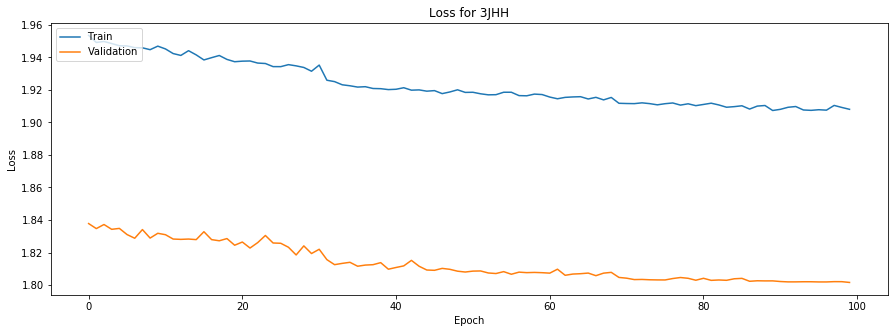

2019-07-31 22:21:12,196 | INFO : Using X_train file M053_0725_0821_3JHH_X_train_meta_fc_f2_0.1754MAE_-1.7409LMAE.parquet
2019-07-31 22:21:12,197 | INFO : Training model for fold 2
2019-07-31 22:21:12,197 | INFO : Creating Datasets
2019-07-31 22:21:13,060 | INFO : Adding target to dataset
2019-07-31 22:21:19,081 | INFO : Adding custom target features
2019-07-31 22:22:33,917 | INFO : Filling in NA vaules with the mean value
2019-07-31 22:22:36,874 | INFO : Applying Standard scalar to data
2019-07-31 22:23:19,918 | INFO : Done creating data for model
Train on 393741 samples, validate on 196870 samples
Epoch 1/500
 - 9s - loss: 4.8645 - out_loss: 1.3470 - outM2_loss: 0.3994 - outT6_loss: 2.3260 - outT12_loss: 0.7920 - val_loss: 4.2632 - val_out_loss: 1.1754 - val_outM2_loss: 0.2904 - val_outT6_loss: 2.0344 - val_outT12_loss: 0.7629
Epoch 2/500
 - 6s - loss: 3.3752 - out_loss: 0.3907 - outM2_loss: 0.2461 - outT6_loss: 1.9771 - outT12_loss: 0.7613 - val_loss: 3.4758 - val_out_loss: 0.6148 - 

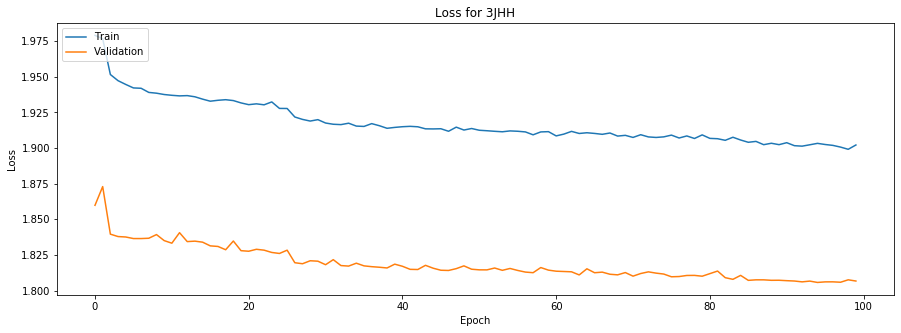

2019-07-31 22:48:06,519 | INFO : Using X_train file M053_0725_0821_3JHH_X_train_meta_fc_f3_0.1754MAE_-1.7409LMAE.parquet
2019-07-31 22:48:06,521 | INFO : Training model for fold 3
2019-07-31 22:48:06,521 | INFO : Creating Datasets
2019-07-31 22:48:07,412 | INFO : Adding target to dataset
2019-07-31 22:48:13,321 | INFO : Adding custom target features
2019-07-31 22:49:33,272 | INFO : Filling in NA vaules with the mean value
2019-07-31 22:49:36,695 | INFO : Applying Standard scalar to data
2019-07-31 22:50:23,185 | INFO : Done creating data for model
Train on 393741 samples, validate on 196870 samples
Epoch 1/500
 - 10s - loss: 4.7354 - out_loss: 1.2283 - outM2_loss: 0.3888 - outT6_loss: 2.3265 - outT12_loss: 0.7918 - val_loss: 4.0864 - val_out_loss: 0.9694 - val_outM2_loss: 0.3244 - val_outT6_loss: 2.0329 - val_outT12_loss: 0.7597
Epoch 2/500
 - 7s - loss: 3.3533 - out_loss: 0.3899 - outM2_loss: 0.2406 - outT6_loss: 1.9622 - outT12_loss: 0.7606 - val_loss: 3.5759 - val_out_loss: 0.6969 -

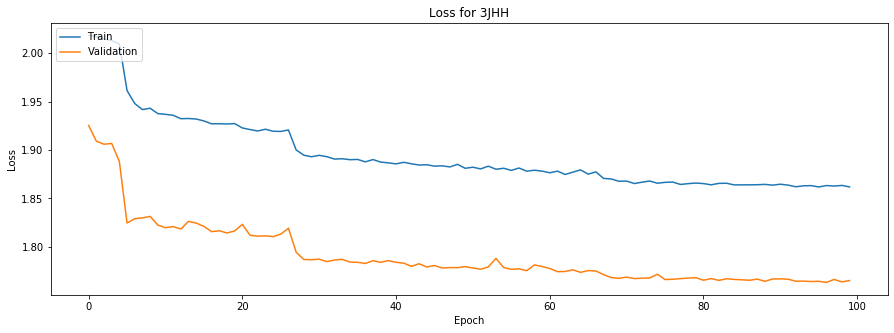

In [11]:
EPOCH_N = 500
INPUT_MODEL = 'M053_0725_0821_3JHH'

cv_score=[]
cv_score_total=0 
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                 MODEL_NUMBER=MODEL_NUMBER,
                                                 bond_type=bond_type,
                                                 X_train_file=X_train_file,
                                                 EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]

2019-07-31 23:12:36,335 | INFO : Plotting Results


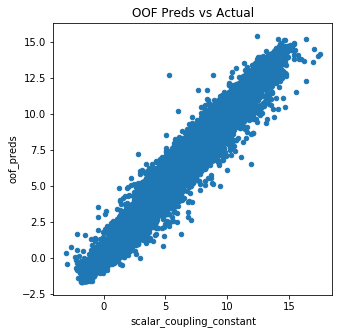

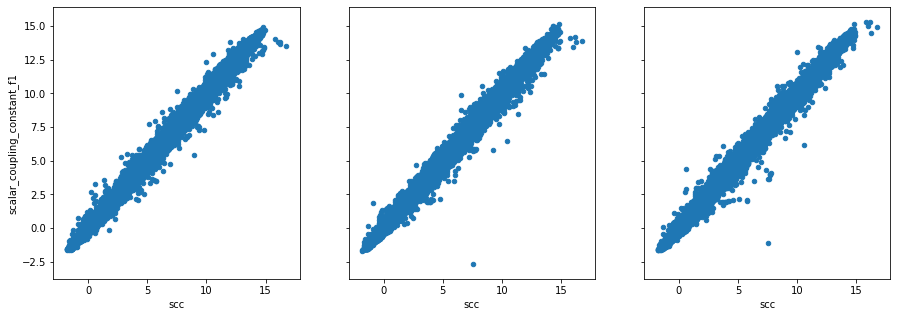

2019-07-31 23:12:52,127 | INFO : Saving Results
===== Saving results for for type 3JHH - mae 0.14412798493636364 - log mae -1.9370535898607097
2019-07-31 23:12:53,496 | INFO : 3JHH: Saving sub to ../type_results/3JHH/K004_0731_2312_3JHH_sub_0.1441MAE_-1.937LMAE_keras_3folds_iter_lr.parquet
2019-07-31 23:12:53,497 | INFO : 3JHH: Saving oof to ../type_results/3JHH/K004_0731_2312_3JHH_oof_0.1441MAE_-1.937LMAE_keras_3folds_iter_lr.parquet


In [12]:
run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

## 1JHC

2019-07-31 23:16:17,777 | INFO : Using X_train file M053_0725_0821_1JHC_X_train_meta_fc_f1_0.5512MAE_-0.5957LMAE.parquet
2019-07-31 23:16:17,777 | INFO : Training model for fold 1
2019-07-31 23:16:17,778 | INFO : Creating Datasets
2019-07-31 23:16:18,750 | INFO : Adding target to dataset
2019-07-31 23:16:24,933 | INFO : Adding custom target features
2019-07-31 23:17:54,525 | INFO : Filling in NA vaules with the mean value
2019-07-31 23:17:58,204 | INFO : Applying Standard scalar to data
2019-07-31 23:18:57,739 | INFO : Done creating data for model
Train on 472944 samples, validate on 236472 samples
Epoch 1/500
 - 12s - loss: 92.8120 - out_loss: 89.9618 - outM2_loss: 0.3878 - outT6_loss: 1.7170 - outT12_loss: 0.7454 - val_loss: 87.3991 - val_out_loss: 84.8920 - val_outM2_loss: 0.2989 - val_outT6_loss: 1.4904 - val_outT12_loss: 0.7177
Epoch 2/500
 - 9s - loss: 83.0326 - out_loss: 80.6664 - outM2_loss: 0.2136 - outT6_loss: 1.4316 - outT12_loss: 0.7210 - val_loss: 77.1333 - val_out_loss: 7

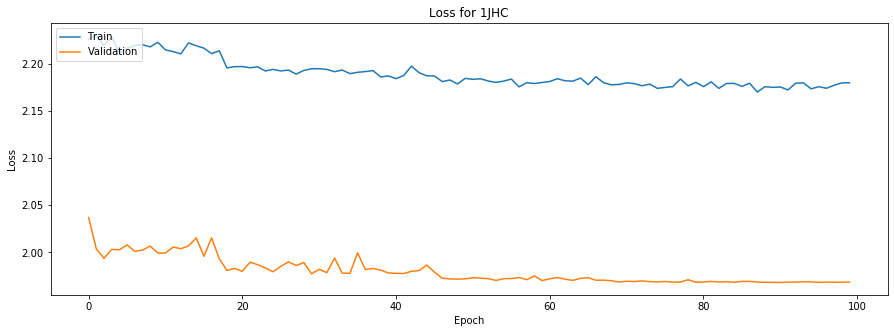

2019-07-31 23:51:57,419 | INFO : Using X_train file M053_0725_0821_1JHC_X_train_meta_fc_f2_0.5495MAE_-0.5987LMAE.parquet
2019-07-31 23:51:57,420 | INFO : Training model for fold 2
2019-07-31 23:51:57,420 | INFO : Creating Datasets
2019-07-31 23:52:08,775 | INFO : Adding target to dataset
2019-07-31 23:52:14,696 | INFO : Adding custom target features
2019-07-31 23:53:43,548 | INFO : Filling in NA vaules with the mean value
2019-07-31 23:53:47,352 | INFO : Applying Standard scalar to data
2019-07-31 23:54:41,287 | INFO : Done creating data for model
Train on 472944 samples, validate on 236472 samples
Epoch 1/500
 - 11s - loss: 92.1594 - out_loss: 89.3068 - outM2_loss: 0.3874 - outT6_loss: 1.7180 - outT12_loss: 0.7472 - val_loss: 87.6302 - val_out_loss: 85.1253 - val_outM2_loss: 0.2706 - val_outT6_loss: 1.5141 - val_outT12_loss: 0.7201
Epoch 2/500
 - 8s - loss: 82.2429 - out_loss: 79.8688 - outM2_loss: 0.2201 - outT6_loss: 1.4327 - outT12_loss: 0.7213 - val_loss: 76.5024 - val_out_loss: 7

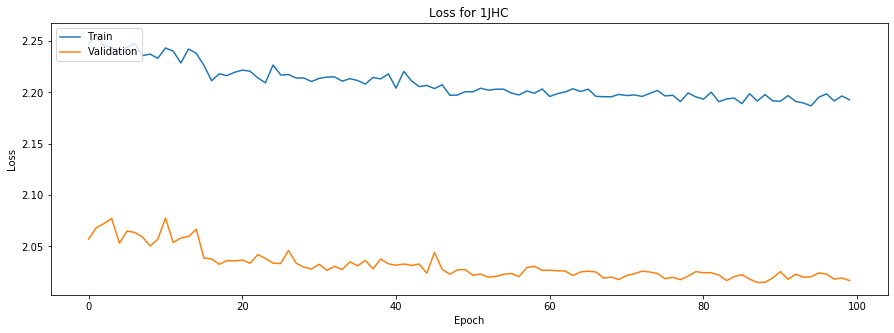

2019-08-01 00:22:41,077 | INFO : Using X_train file M053_0725_0821_1JHC_X_train_meta_fc_f3_0.5515MAE_-0.5952LMAE.parquet
2019-08-01 00:22:41,078 | INFO : Training model for fold 3
2019-08-01 00:22:41,078 | INFO : Creating Datasets
2019-08-01 00:22:50,375 | INFO : Adding target to dataset
2019-08-01 00:22:56,343 | INFO : Adding custom target features
2019-08-01 00:24:25,725 | INFO : Filling in NA vaules with the mean value
2019-08-01 00:24:29,341 | INFO : Applying Standard scalar to data
2019-08-01 00:25:25,096 | INFO : Done creating data for model
Train on 472944 samples, validate on 236472 samples
Epoch 1/500
 - 12s - loss: 92.7978 - out_loss: 89.9447 - outM2_loss: 0.3929 - outT6_loss: 1.7140 - outT12_loss: 0.7462 - val_loss: 87.2410 - val_out_loss: 84.7251 - val_outM2_loss: 0.3057 - val_outT6_loss: 1.4897 - val_outT12_loss: 0.7204
Epoch 2/500
 - 8s - loss: 82.4261 - out_loss: 80.0566 - outM2_loss: 0.2153 - outT6_loss: 1.4336 - outT12_loss: 0.7207 - val_loss: 76.1737 - val_out_loss: 7

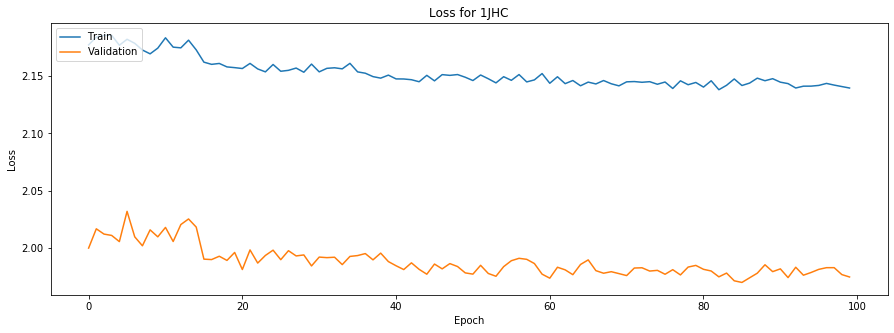

In [15]:
EPOCH_N = 500
INPUT_MODEL = 'M053_0725_0821_1JHC'
bond_type = '1JHC'
# cv_score=[]
# cv_score_total=0
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                          MODEL_NUMBER=MODEL_NUMBER,
                                                          bond_type=bond_type,
                                                          X_train_file=X_train_file,
                                                          EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]

2019-08-01 01:02:17,287 | INFO : Plotting Results


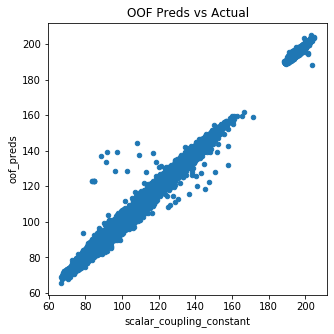

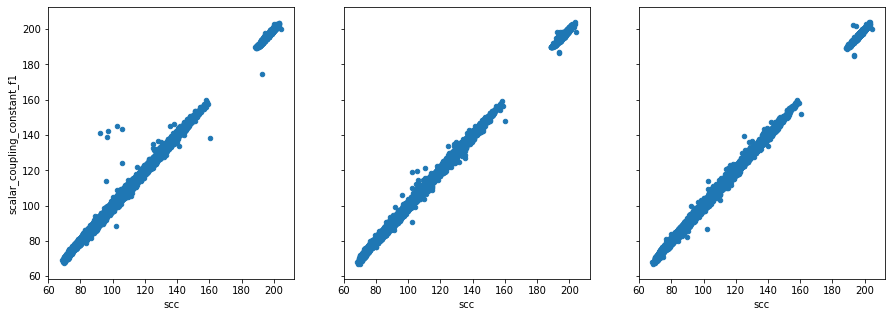

2019-08-01 01:02:35,848 | INFO : Saving Results
===== Saving results for for type 1JHC - mae 0.45918944109224297 - log mae -0.7782924283782512
2019-08-01 01:02:37,310 | INFO : 1JHC: Saving sub to ../type_results/1JHC/K004_0731_2312_1JHC_sub_0.4592MAE_-0.7783LMAE_keras_3folds_iter_lr.parquet
2019-08-01 01:02:37,311 | INFO : 1JHC: Saving oof to ../type_results/1JHC/K004_0731_2312_1JHC_oof_0.4592MAE_-0.7783LMAE_keras_3folds_iter_lr.parquet


In [16]:
#run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

# 1JHN

2019-08-01 01:02:38,678 | INFO : Using X_train file M056_0728_1722_1JHN_X_train_meta_fc_f1_0.3497MAE_-1.0506LMAE.parquet
2019-08-01 01:02:38,679 | INFO : Training model for fold 1
2019-08-01 01:02:38,679 | INFO : Creating Datasets
2019-08-01 01:02:38,975 | INFO : Adding target to dataset
2019-08-01 01:02:40,322 | INFO : Adding custom target features
2019-08-01 01:02:48,799 | INFO : Filling in NA vaules with the mean value
2019-08-01 01:02:51,430 | INFO : Applying Standard scalar to data
2019-08-01 01:02:57,114 | INFO : Done creating data for model
Train on 28908 samples, validate on 14455 samples
Epoch 1/500
 - 4s - loss: 51.1263 - out_loss: 46.4473 - outM2_loss: 1.4592 - outT6_loss: 2.3122 - outT12_loss: 0.9076 - val_loss: 48.7027 - val_out_loss: 44.3957 - val_outM2_loss: 1.2464 - val_outT6_loss: 2.2185 - val_outT12_loss: 0.8422
Epoch 2/500
 - 0s - loss: 47.9541 - out_loss: 44.6745 - outM2_loss: 0.6332 - outT6_loss: 1.8860 - outT12_loss: 0.7604 - val_loss: 44.8068 - val_out_loss: 40.4

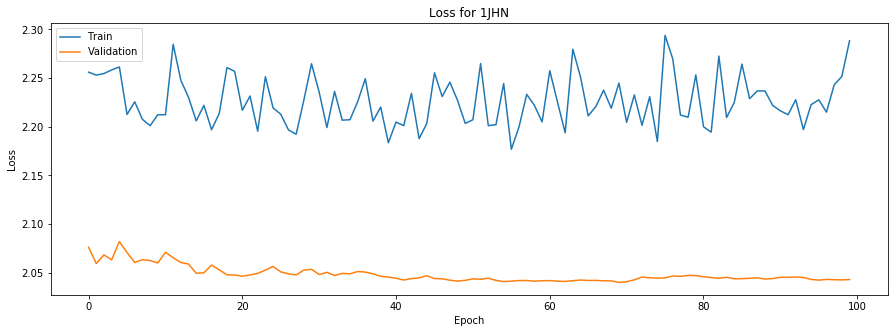

2019-08-01 01:05:30,113 | INFO : Using X_train file M056_0728_1722_1JHN_X_train_meta_fc_f2_0.3493MAE_-1.0519LMAE.parquet
2019-08-01 01:05:30,114 | INFO : Training model for fold 2
2019-08-01 01:05:30,114 | INFO : Creating Datasets
2019-08-01 01:05:30,408 | INFO : Adding target to dataset
2019-08-01 01:05:31,838 | INFO : Adding custom target features
2019-08-01 01:05:41,539 | INFO : Filling in NA vaules with the mean value
2019-08-01 01:05:44,282 | INFO : Applying Standard scalar to data
2019-08-01 01:05:50,442 | INFO : Done creating data for model
Train on 28909 samples, validate on 14454 samples
Epoch 1/500
 - 5s - loss: 50.8243 - out_loss: 46.1715 - outM2_loss: 1.4537 - outT6_loss: 2.2793 - outT12_loss: 0.9197 - val_loss: 51.7800 - val_out_loss: 47.3529 - val_outM2_loss: 1.3737 - val_outT6_loss: 2.2024 - val_outT12_loss: 0.8510
Epoch 2/500
 - 0s - loss: 47.8370 - out_loss: 44.5212 - outM2_loss: 0.6604 - outT6_loss: 1.8890 - outT12_loss: 0.7664 - val_loss: 47.8833 - val_out_loss: 43.6

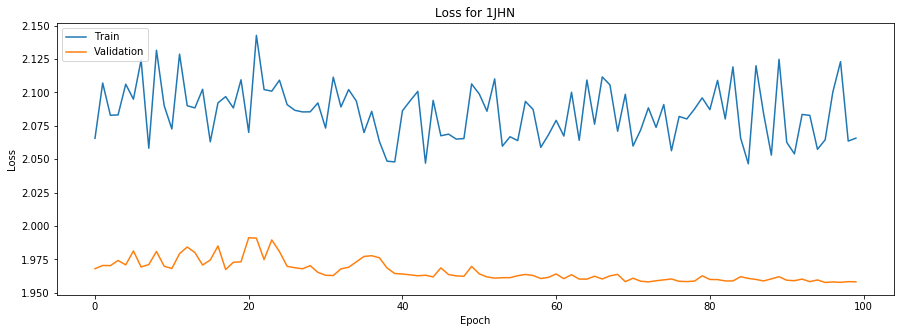

2019-08-01 01:08:48,502 | INFO : Using X_train file M056_0728_1722_1JHN_X_train_meta_fc_f3_0.3475MAE_-1.0569LMAE.parquet
2019-08-01 01:08:48,502 | INFO : Training model for fold 3
2019-08-01 01:08:48,503 | INFO : Creating Datasets
2019-08-01 01:08:48,751 | INFO : Adding target to dataset
2019-08-01 01:08:50,128 | INFO : Adding custom target features
2019-08-01 01:08:58,184 | INFO : Filling in NA vaules with the mean value
2019-08-01 01:09:00,776 | INFO : Applying Standard scalar to data
2019-08-01 01:09:06,439 | INFO : Done creating data for model
Train on 28909 samples, validate on 14454 samples
Epoch 1/500
 - 5s - loss: 51.0477 - out_loss: 46.4494 - outM2_loss: 1.4008 - outT6_loss: 2.2865 - outT12_loss: 0.9109 - val_loss: 52.4440 - val_out_loss: 48.4967 - val_outM2_loss: 0.8809 - val_outT6_loss: 2.2215 - val_outT12_loss: 0.8449
Epoch 2/500
 - 0s - loss: 48.0483 - out_loss: 44.7513 - outM2_loss: 0.6343 - outT6_loss: 1.8974 - outT12_loss: 0.7653 - val_loss: 47.0813 - val_out_loss: 42.5

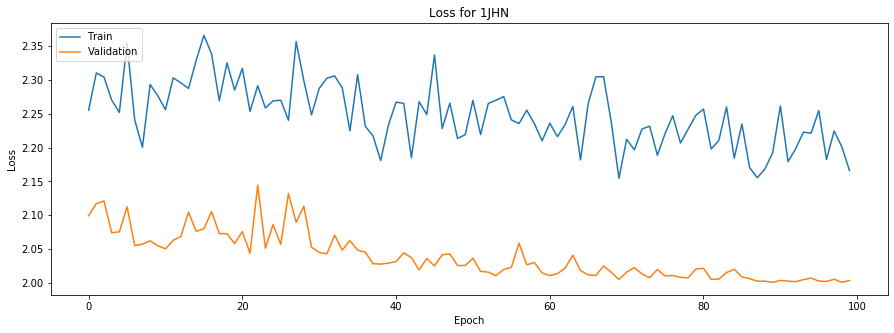

In [17]:
EPOCH_N = 500
INPUT_MODEL = 'M056_0728_1722_1JHN'
bond_type = '1JHN'
# cv_score=[]
# cv_score_total=0
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                          MODEL_NUMBER=MODEL_NUMBER,
                                                          bond_type=bond_type,
                                                          X_train_file=X_train_file,
                                                          EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]

2019-08-01 01:11:22,130 | INFO : Plotting Results


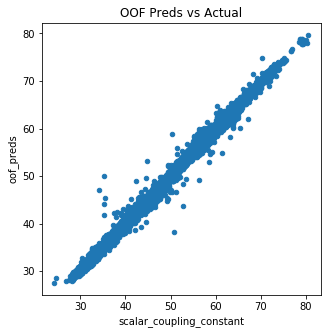

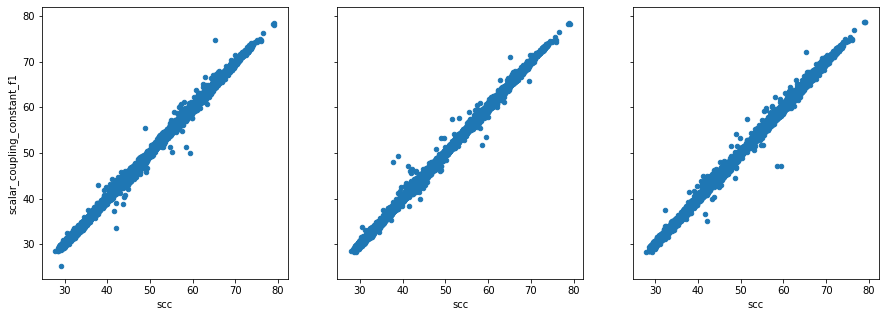

2019-08-01 01:11:24,157 | INFO : Saving Results
===== Saving results for for type 1JHN - mae 0.2971341807181007 - log mae -1.2135714552747925
2019-08-01 01:11:24,832 | INFO : 1JHN: Saving sub to ../type_results/1JHN/K004_0731_2312_1JHN_sub_0.2971MAE_-1.214LMAE_keras_3folds_iter_lr.parquet
2019-08-01 01:11:24,833 | INFO : 1JHN: Saving oof to ../type_results/1JHN/K004_0731_2312_1JHN_oof_0.2971MAE_-1.214LMAE_keras_3folds_iter_lr.parquet


In [18]:
#run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

# 2JHC

2019-08-01 01:11:26,328 | INFO : Using X_train file M055_0726_2356_2JHC_X_train_meta_fc_f1_0.2278MAE_-1.4794LMAE.parquet
2019-08-01 01:11:26,329 | INFO : Training model for fold 1
2019-08-01 01:11:26,329 | INFO : Creating Datasets
2019-08-01 01:11:34,928 | INFO : Adding target to dataset
2019-08-01 01:11:43,473 | INFO : Adding custom target features
2019-08-01 01:14:49,807 | INFO : Filling in NA vaules with the mean value
2019-08-01 01:16:12,706 | INFO : Applying Standard scalar to data
2019-08-01 01:19:38,874 | INFO : Done creating data for model
Train on 760449 samples, validate on 380225 samples
Epoch 1/500
 - 23s - loss: 3.3968 - out_loss: 0.6344 - outM2_loss: 0.3088 - outT6_loss: 1.7272 - outT12_loss: 0.7265 - val_loss: 3.4336 - val_out_loss: 0.9222 - val_outM2_loss: 0.2951 - val_outT6_loss: 1.5180 - val_outT12_loss: 0.6983
Epoch 2/500
 - 17s - loss: 2.7775 - out_loss: 0.3939 - outM2_loss: 0.1954 - outT6_loss: 1.4869 - outT12_loss: 0.7012 - val_loss: 2.8147 - val_out_loss: 0.5605 

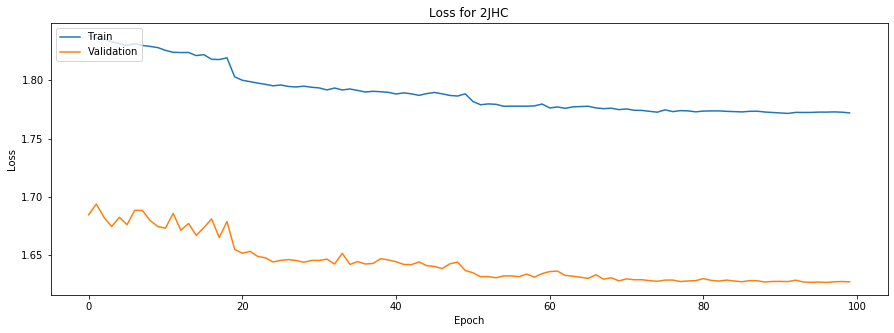

2019-08-01 02:08:48,941 | INFO : Using X_train file M055_0726_2356_2JHC_X_train_meta_fc_f2_0.2272MAE_-1.4819LMAE.parquet
2019-08-01 02:08:48,941 | INFO : Training model for fold 2
2019-08-01 02:08:48,942 | INFO : Creating Datasets
2019-08-01 02:08:56,874 | INFO : Adding target to dataset
2019-08-01 02:09:05,746 | INFO : Adding custom target features
2019-08-01 02:11:51,508 | INFO : Filling in NA vaules with the mean value
2019-08-01 02:13:06,613 | INFO : Applying Standard scalar to data
2019-08-01 02:16:18,411 | INFO : Done creating data for model
Train on 760449 samples, validate on 380225 samples
Epoch 1/500
 - 23s - loss: 3.4040 - out_loss: 0.6366 - outM2_loss: 0.3108 - outT6_loss: 1.7291 - outT12_loss: 0.7276 - val_loss: 3.6143 - val_out_loss: 1.0991 - val_outM2_loss: 0.2492 - val_outT6_loss: 1.5646 - val_outT12_loss: 0.7014
Epoch 2/500
 - 17s - loss: 2.7820 - out_loss: 0.3941 - outM2_loss: 0.1986 - outT6_loss: 1.4890 - outT12_loss: 0.7003 - val_loss: 2.8918 - val_out_loss: 0.6482 

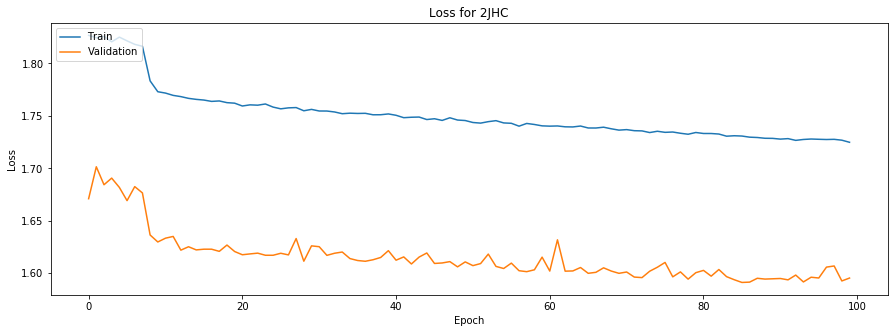

2019-08-01 03:14:28,672 | INFO : Using X_train file M055_0726_2356_2JHC_X_train_meta_fc_f3_0.2286MAE_-1.4758LMAE.parquet
2019-08-01 03:14:28,673 | INFO : Training model for fold 3
2019-08-01 03:14:28,673 | INFO : Creating Datasets
2019-08-01 03:14:36,022 | INFO : Adding target to dataset
2019-08-01 03:14:43,929 | INFO : Adding custom target features
2019-08-01 03:17:54,845 | INFO : Filling in NA vaules with the mean value
2019-08-01 03:19:13,665 | INFO : Applying Standard scalar to data
2019-08-01 03:22:24,706 | INFO : Done creating data for model
Train on 760450 samples, validate on 380224 samples
Epoch 1/500
 - 19s - loss: 3.3895 - out_loss: 0.6243 - outM2_loss: 0.3160 - outT6_loss: 1.7227 - outT12_loss: 0.7264 - val_loss: 3.4737 - val_out_loss: 0.9595 - val_outM2_loss: 0.2836 - val_outT6_loss: 1.5286 - val_outT12_loss: 0.7020
Epoch 2/500
 - 14s - loss: 2.7824 - out_loss: 0.3990 - outM2_loss: 0.1959 - outT6_loss: 1.4877 - outT12_loss: 0.6998 - val_loss: 2.9375 - val_out_loss: 0.6822 

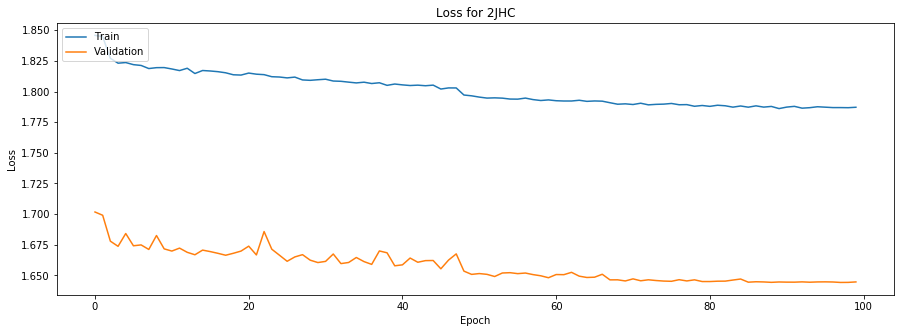

2019-08-01 04:08:07,645 | INFO : Plotting Results


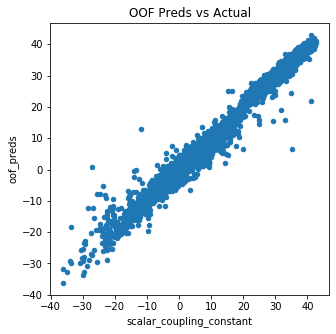

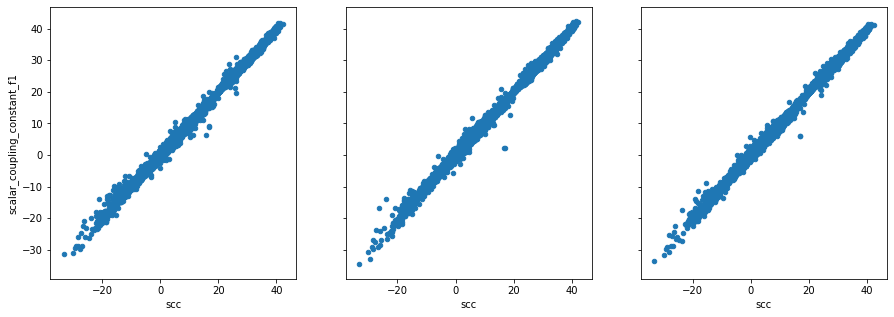

2019-08-01 04:08:37,844 | INFO : Saving Results
===== Saving results for for type 2JHC - mae 0.18871684836907288 - log mae -1.6675075440588705
2019-08-01 04:08:39,648 | INFO : 2JHC: Saving sub to ../type_results/2JHC/K004_0731_2312_2JHC_sub_0.1887MAE_-1.668LMAE_keras_3folds_iter_lr.parquet
2019-08-01 04:08:39,648 | INFO : 2JHC: Saving oof to ../type_results/2JHC/K004_0731_2312_2JHC_oof_0.1887MAE_-1.668LMAE_keras_3folds_iter_lr.parquet


In [19]:
EPOCH_N = 500
INPUT_MODEL = 'M055_0726_2356_2JHC'
bond_type = '2JHC'
# cv_score=[]
# cv_score_total=0
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                          MODEL_NUMBER=MODEL_NUMBER,
                                                          bond_type=bond_type,
                                                          X_train_file=X_train_file,
                                                          EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]
    
#run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

# 2JHH

2019-08-01 04:08:41,386 | INFO : Using X_train file M055_0728_1938_2JHH_X_train_meta_fc_f1_0.1341MAE_-2.0095LMAE.parquet
2019-08-01 04:08:41,386 | INFO : Training model for fold 1
2019-08-01 04:08:41,386 | INFO : Creating Datasets
2019-08-01 04:08:44,138 | INFO : Adding target to dataset
2019-08-01 04:08:47,572 | INFO : Adding custom target features
2019-08-01 04:09:21,386 | INFO : Filling in NA vaules with the mean value
2019-08-01 04:09:23,005 | INFO : Applying Standard scalar to data
2019-08-01 04:09:44,594 | INFO : Done creating data for model
Train on 252024 samples, validate on 126012 samples
Epoch 1/500
 - 10s - loss: 10.3559 - out_loss: 6.4440 - outM2_loss: 0.4677 - outT6_loss: 2.6027 - outT12_loss: 0.8415 - val_loss: 8.9816 - val_out_loss: 5.5697 - val_outM2_loss: 0.3314 - val_outT6_loss: 2.2757 - val_outT12_loss: 0.8048
Epoch 2/500
 - 4s - loss: 6.3246 - out_loss: 3.0313 - outM2_loss: 0.2704 - outT6_loss: 2.2154 - outT12_loss: 0.8074 - val_loss: 6.9776 - val_out_loss: 3.7284 

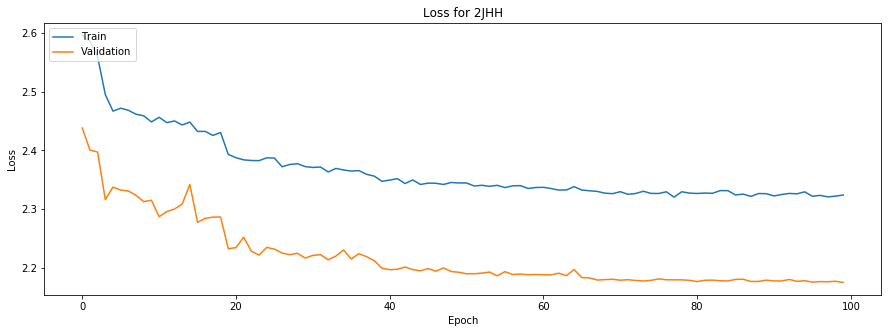

2019-08-01 04:19:08,992 | INFO : Using X_train file M055_0728_1938_2JHH_X_train_meta_fc_f2_0.1340MAE_-2.0099LMAE.parquet
2019-08-01 04:19:08,992 | INFO : Training model for fold 2
2019-08-01 04:19:08,993 | INFO : Creating Datasets
2019-08-01 04:19:11,743 | INFO : Adding target to dataset
2019-08-01 04:19:15,613 | INFO : Adding custom target features
2019-08-01 04:19:55,647 | INFO : Filling in NA vaules with the mean value
2019-08-01 04:19:57,533 | INFO : Applying Standard scalar to data
2019-08-01 04:20:21,673 | INFO : Done creating data for model
Train on 252024 samples, validate on 126012 samples
Epoch 1/500
 - 11s - loss: 11.1010 - out_loss: 7.1991 - outM2_loss: 0.4679 - outT6_loss: 2.5967 - outT12_loss: 0.8372 - val_loss: 8.4479 - val_out_loss: 5.0644 - val_outM2_loss: 0.3001 - val_outT6_loss: 2.2777 - val_outT12_loss: 0.8057
Epoch 2/500
 - 4s - loss: 6.8160 - out_loss: 3.5422 - outM2_loss: 0.2624 - outT6_loss: 2.2052 - outT12_loss: 0.8062 - val_loss: 6.1129 - val_out_loss: 2.9198 

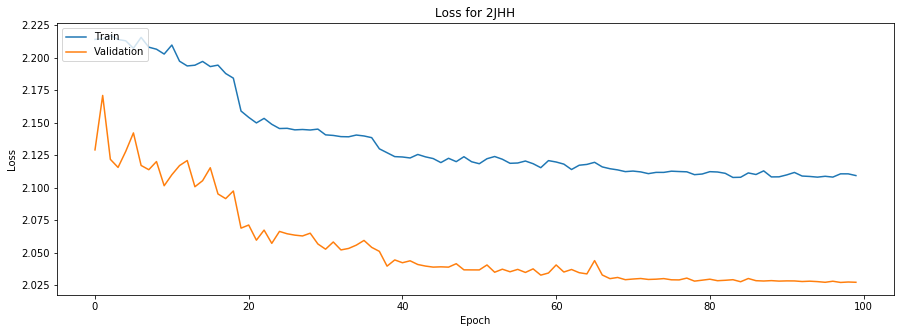

2019-08-01 04:34:26,484 | INFO : Using X_train file M055_0728_1938_2JHH_X_train_meta_fc_f3_0.1329MAE_-2.0183LMAE.parquet
2019-08-01 04:34:26,485 | INFO : Training model for fold 3
2019-08-01 04:34:26,485 | INFO : Creating Datasets
2019-08-01 04:34:29,476 | INFO : Adding target to dataset
2019-08-01 04:34:32,820 | INFO : Adding custom target features
2019-08-01 04:35:06,281 | INFO : Filling in NA vaules with the mean value
2019-08-01 04:35:07,876 | INFO : Applying Standard scalar to data
2019-08-01 04:35:30,585 | INFO : Done creating data for model
Train on 252024 samples, validate on 126012 samples
Epoch 1/500
 - 12s - loss: 11.1735 - out_loss: 7.2598 - outM2_loss: 0.4751 - outT6_loss: 2.5979 - outT12_loss: 0.8407 - val_loss: 7.1525 - val_out_loss: 3.6833 - val_outM2_loss: 0.3874 - val_outT6_loss: 2.2762 - val_outT12_loss: 0.8056
Epoch 2/500
 - 4s - loss: 6.6351 - out_loss: 3.3583 - outM2_loss: 0.2661 - outT6_loss: 2.2028 - outT12_loss: 0.8080 - val_loss: 4.5779 - val_out_loss: 1.4559 

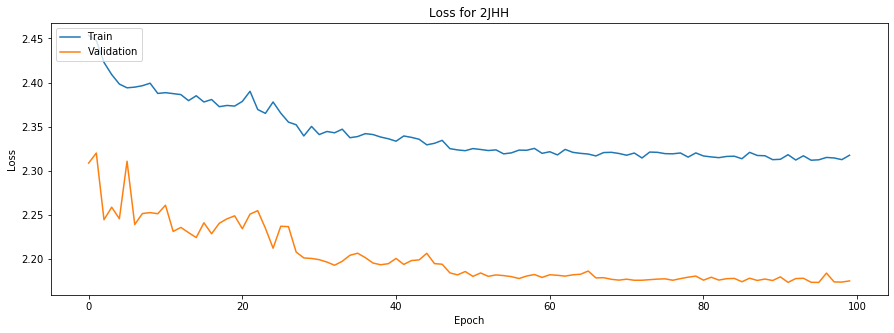

2019-08-01 04:46:05,552 | INFO : Plotting Results


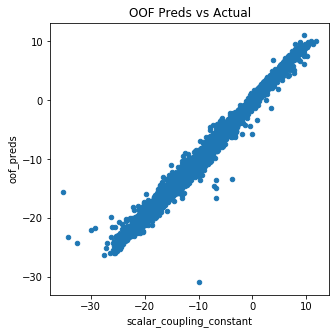

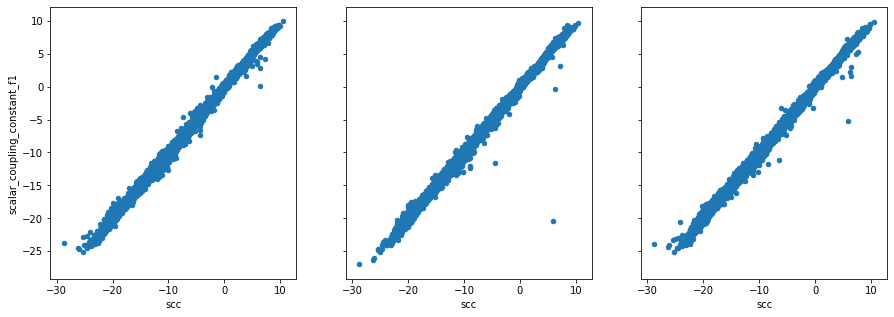

2019-08-01 04:46:16,159 | INFO : Saving Results
===== Saving results for for type 2JHH - mae 0.1171088571979283 - log mae -2.144651373340248
2019-08-01 04:46:17,168 | INFO : 2JHH: Saving sub to ../type_results/2JHH/K004_0731_2312_2JHH_sub_0.1171MAE_-2.145LMAE_keras_3folds_iter_lr.parquet
2019-08-01 04:46:17,169 | INFO : 2JHH: Saving oof to ../type_results/2JHH/K004_0731_2312_2JHH_oof_0.1171MAE_-2.145LMAE_keras_3folds_iter_lr.parquet


In [20]:
EPOCH_N = 500
INPUT_MODEL = 'M055_0728_1938_2JHH'
bond_type = '2JHH'
# cv_score=[]
# cv_score_total=0
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                          MODEL_NUMBER=MODEL_NUMBER,
                                                          bond_type=bond_type,
                                                          X_train_file=X_train_file,
                                                          EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]
    
#run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

# 2JHN

2019-08-01 04:46:18,589 | INFO : Using X_train file M056_0728_1731_2JHN_X_train_meta_fc_f1_0.1792MAE_-1.7192LMAE.parquet
2019-08-01 04:46:18,590 | INFO : Training model for fold 1
2019-08-01 04:46:18,590 | INFO : Creating Datasets
2019-08-01 04:46:19,403 | INFO : Adding target to dataset
2019-08-01 04:46:21,284 | INFO : Adding custom target features
2019-08-01 04:46:35,092 | INFO : Filling in NA vaules with the mean value
2019-08-01 04:46:40,932 | INFO : Applying Standard scalar to data
2019-08-01 04:46:54,729 | INFO : Done creating data for model
Train on 79502 samples, validate on 39751 samples
Epoch 1/500
 - 8s - loss: 5.5987 - out_loss: 1.9191 - outM2_loss: 0.7454 - outT6_loss: 2.0886 - outT12_loss: 0.8456 - val_loss: 6.5816 - val_out_loss: 2.7651 - val_outM2_loss: 0.8289 - val_outT6_loss: 2.2213 - val_outT12_loss: 0.7664
Epoch 2/500
 - 1s - loss: 3.5324 - out_loss: 0.6265 - outM2_loss: 0.3559 - outT6_loss: 1.8075 - outT12_loss: 0.7425 - val_loss: 4.8073 - val_out_loss: 1.4856 - va

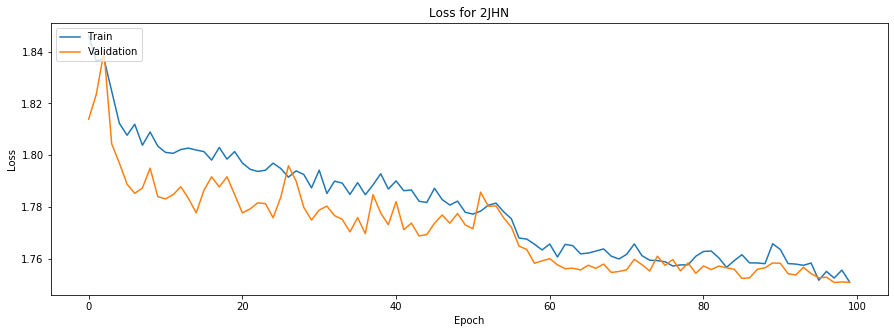

2019-08-01 04:51:36,605 | INFO : Using X_train file M056_0728_1731_2JHN_X_train_meta_fc_f2_0.1786MAE_-1.7227LMAE.parquet
2019-08-01 04:51:36,606 | INFO : Training model for fold 2
2019-08-01 04:51:36,606 | INFO : Creating Datasets
2019-08-01 04:51:37,525 | INFO : Adding target to dataset
2019-08-01 04:51:39,379 | INFO : Adding custom target features
2019-08-01 04:51:53,234 | INFO : Filling in NA vaules with the mean value
2019-08-01 04:51:59,087 | INFO : Applying Standard scalar to data
2019-08-01 04:52:12,895 | INFO : Done creating data for model
Train on 79502 samples, validate on 39751 samples
Epoch 1/500
 - 8s - loss: 5.6337 - out_loss: 1.9110 - outM2_loss: 0.7780 - outT6_loss: 2.0984 - outT12_loss: 0.8463 - val_loss: 6.8838 - val_out_loss: 2.8852 - val_outM2_loss: 0.9123 - val_outT6_loss: 2.3220 - val_outT12_loss: 0.7643
Epoch 2/500
 - 1s - loss: 3.5043 - out_loss: 0.5938 - outM2_loss: 0.3501 - outT6_loss: 1.8146 - outT12_loss: 0.7458 - val_loss: 4.6986 - val_out_loss: 1.4883 - va

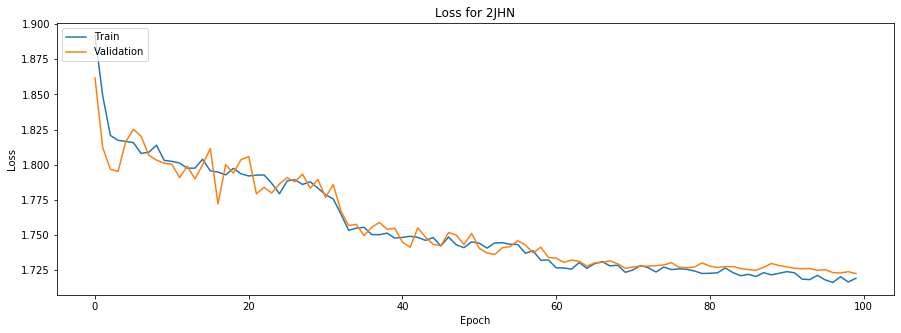

2019-08-01 04:56:34,057 | INFO : Using X_train file M056_0728_1731_2JHN_X_train_meta_fc_f3_0.1792MAE_-1.7193LMAE.parquet
2019-08-01 04:56:34,058 | INFO : Training model for fold 3
2019-08-01 04:56:34,058 | INFO : Creating Datasets
2019-08-01 04:56:34,935 | INFO : Adding target to dataset
2019-08-01 04:56:36,886 | INFO : Adding custom target features
2019-08-01 04:56:50,663 | INFO : Filling in NA vaules with the mean value
2019-08-01 04:56:56,602 | INFO : Applying Standard scalar to data
2019-08-01 04:57:10,438 | INFO : Done creating data for model
Train on 79502 samples, validate on 39751 samples
Epoch 1/500
 - 8s - loss: 5.3734 - out_loss: 1.7158 - outM2_loss: 0.7151 - outT6_loss: 2.1016 - outT12_loss: 0.8409 - val_loss: 6.4281 - val_out_loss: 2.3918 - val_outM2_loss: 0.9448 - val_outT6_loss: 2.3132 - val_outT12_loss: 0.7783
Epoch 2/500
 - 1s - loss: 3.4304 - out_loss: 0.5230 - outM2_loss: 0.3530 - outT6_loss: 1.8121 - outT12_loss: 0.7423 - val_loss: 4.4698 - val_out_loss: 1.2645 - va

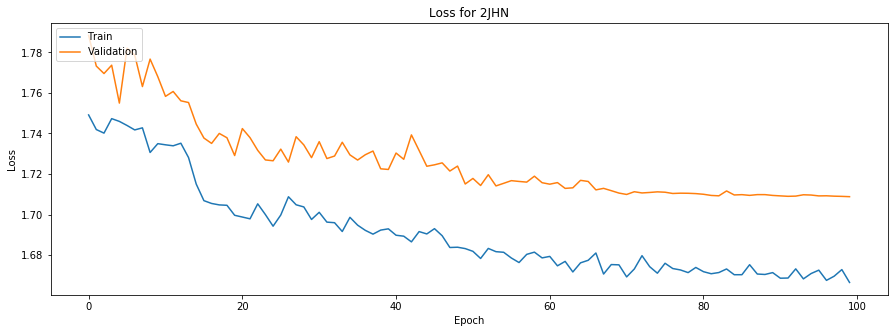

2019-08-01 05:02:16,660 | INFO : Plotting Results


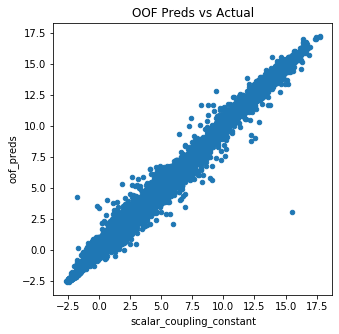

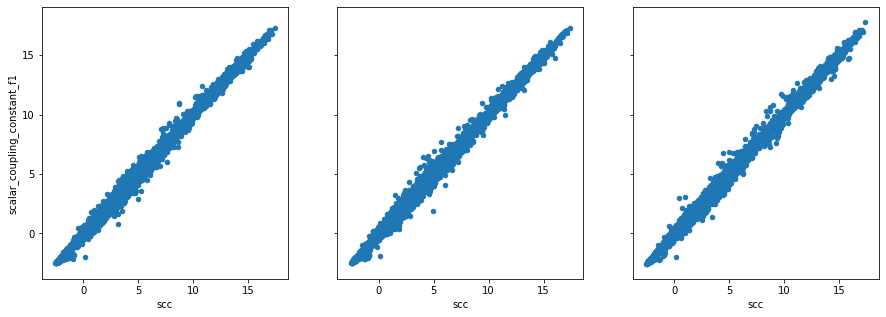

2019-08-01 05:02:20,607 | INFO : Saving Results
===== Saving results for for type 2JHN - mae 0.12183256039615195 - log mae -2.1051076326981693
2019-08-01 05:02:21,315 | INFO : 2JHN: Saving sub to ../type_results/2JHN/K004_0731_2312_2JHN_sub_0.1218MAE_-2.105LMAE_keras_3folds_iter_lr.parquet
2019-08-01 05:02:21,316 | INFO : 2JHN: Saving oof to ../type_results/2JHN/K004_0731_2312_2JHN_oof_0.1218MAE_-2.105LMAE_keras_3folds_iter_lr.parquet


In [21]:
EPOCH_N = 500
INPUT_MODEL = 'M056_0728_1731_2JHN'
bond_type = '2JHN'
# cv_score=[]
# cv_score_total=0
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                          MODEL_NUMBER=MODEL_NUMBER,
                                                          bond_type=bond_type,
                                                          X_train_file=X_train_file,
                                                          EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]
    
#run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

# 3JHC

2019-08-01 11:32:20,973 | INFO : Using X_train file M055_0728_1938_3JHC_X_train_meta_fc_f1_0.2620MAE_-1.3395LMAE.parquet
2019-08-01 11:32:20,973 | INFO : Training model for fold 1
2019-08-01 11:32:20,974 | INFO : Creating Datasets
2019-08-01 11:32:27,657 | INFO : Adding target to dataset
2019-08-01 11:32:35,605 | INFO : Adding custom target features
2019-08-01 11:35:09,706 | INFO : Filling in NA vaules with the mean value
2019-08-01 11:36:31,914 | INFO : Applying Standard scalar to data
2019-08-01 11:44:20,845 | INFO : Done creating data for model
2019-08-01 11:44:21,169 | WARNING : From /home/robmulla/anaconda3/envs/kaggle/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2019-08-01 11:44:21,273 | WARNING : From /home/robmulla/anaconda3/envs/kaggle/lib/python3.6/site-packages/ker

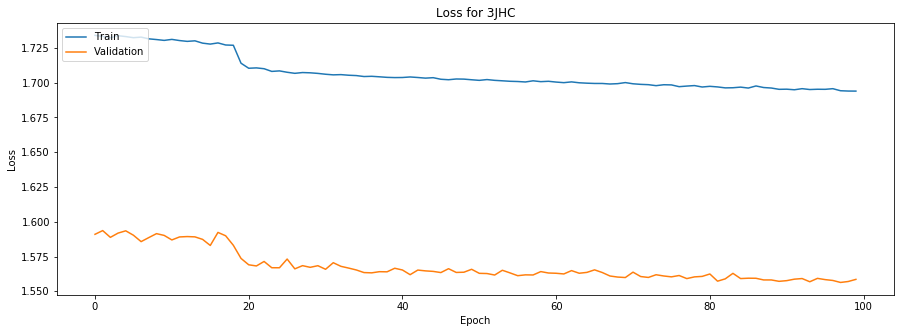

2019-08-01 13:36:42,770 | INFO : Using X_train file M055_0728_1938_3JHC_X_train_meta_fc_f2_0.2616MAE_-1.3411LMAE.parquet
2019-08-01 13:36:42,771 | INFO : Training model for fold 2
2019-08-01 13:36:42,771 | INFO : Creating Datasets
2019-08-01 13:36:49,830 | INFO : Adding target to dataset
2019-08-01 13:36:58,018 | INFO : Adding custom target features
2019-08-01 13:39:33,911 | INFO : Filling in NA vaules with the mean value
2019-08-01 13:41:12,407 | INFO : Applying Standard scalar to data


In [ ]:
EPOCH_N = 500
INPUT_MODEL = 'M055_0728_1938_3JHC'
bond_type = '3JHC'
# cv_score=[]
# cv_score_total=0
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                          MODEL_NUMBER=MODEL_NUMBER,
                                                          bond_type=bond_type,
                                                          X_train_file=X_train_file,
                                                          EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]
    
run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

# 3JHN

2019-08-01 14:22:24,173 | INFO : Using X_train file M055_0726_2356_3JHN_X_train_meta_fc_f1_0.1334MAE_-2.0143LMAE.parquet
2019-08-01 14:22:24,174 | INFO : Training model for fold 1
2019-08-01 14:22:24,174 | INFO : Creating Datasets
2019-08-01 14:22:26,395 | INFO : Adding target to dataset
2019-08-01 14:22:29,365 | INFO : Adding custom target features
2019-08-01 14:23:03,128 | INFO : Filling in NA vaules with the mean value
2019-08-01 14:23:12,389 | INFO : Applying Standard scalar to data
2019-08-01 14:23:41,386 | INFO : Done creating data for model
2019-08-01 14:23:41,431 | WARNING : From /home/robmulla/anaconda3/envs/kaggle/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2019-08-01 14:23:41,509 | WARNING : From /home/robmulla/anaconda3/envs/kaggle/lib/python3.6/site-packages/ker

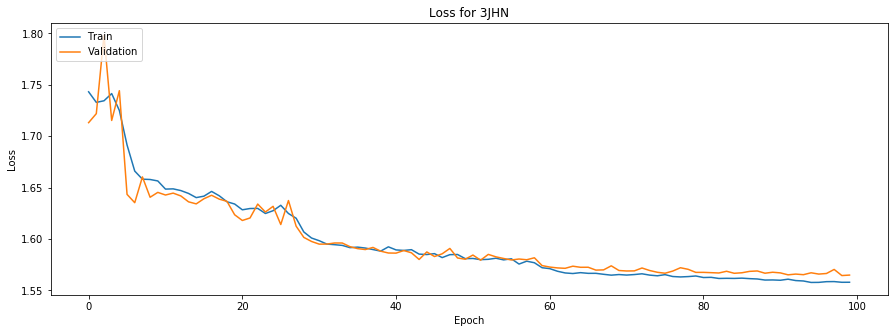

2019-08-01 14:28:30,705 | INFO : Using X_train file M055_0726_2356_3JHN_X_train_meta_fc_f2_0.1336MAE_-2.0128LMAE.parquet
2019-08-01 14:28:30,705 | INFO : Training model for fold 2
2019-08-01 14:28:30,706 | INFO : Creating Datasets
2019-08-01 14:28:32,608 | INFO : Adding target to dataset
2019-08-01 14:28:35,666 | INFO : Adding custom target features
2019-08-01 14:29:08,898 | INFO : Filling in NA vaules with the mean value
2019-08-01 14:29:18,007 | INFO : Applying Standard scalar to data
2019-08-01 14:29:47,156 | INFO : Done creating data for model
Train on 110943 samples, validate on 55472 samples
Epoch 1/500
 - 4s - loss: 4.0840 - out_loss: 0.6152 - outM2_loss: 0.6832 - outT6_loss: 1.9409 - outT12_loss: 0.8446 - val_loss: 4.5569 - val_out_loss: 0.9052 - val_outM2_loss: 0.8780 - val_outT6_loss: 2.0114 - val_outT12_loss: 0.7624
Epoch 2/500
 - 2s - loss: 2.9604 - out_loss: 0.2934 - outM2_loss: 0.3378 - outT6_loss: 1.5907 - outT12_loss: 0.7386 - val_loss: 3.3478 - val_out_loss: 0.4390 - v

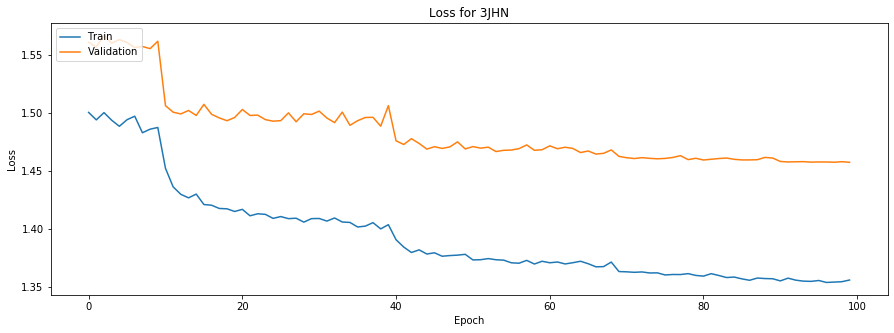

2019-08-01 14:37:35,889 | INFO : Using X_train file M055_0726_2356_3JHN_X_train_meta_fc_f3_0.1339MAE_-2.0105LMAE.parquet
2019-08-01 14:37:35,890 | INFO : Training model for fold 3
2019-08-01 14:37:35,891 | INFO : Creating Datasets
2019-08-01 14:37:37,726 | INFO : Adding target to dataset
2019-08-01 14:37:40,525 | INFO : Adding custom target features
2019-08-01 14:38:13,834 | INFO : Filling in NA vaules with the mean value
2019-08-01 14:38:22,823 | INFO : Applying Standard scalar to data
2019-08-01 14:38:52,042 | INFO : Done creating data for model
Train on 110944 samples, validate on 55471 samples
Epoch 1/500
 - 4s - loss: 4.1478 - out_loss: 0.5747 - outM2_loss: 0.7702 - outT6_loss: 1.9559 - outT12_loss: 0.8471 - val_loss: 4.3165 - val_out_loss: 0.7517 - val_outM2_loss: 0.7563 - val_outT6_loss: 2.0471 - val_outT12_loss: 0.7614
Epoch 2/500
 - 2s - loss: 2.9831 - out_loss: 0.2996 - outM2_loss: 0.3480 - outT6_loss: 1.5939 - outT12_loss: 0.7415 - val_loss: 3.4368 - val_out_loss: 0.4860 - v

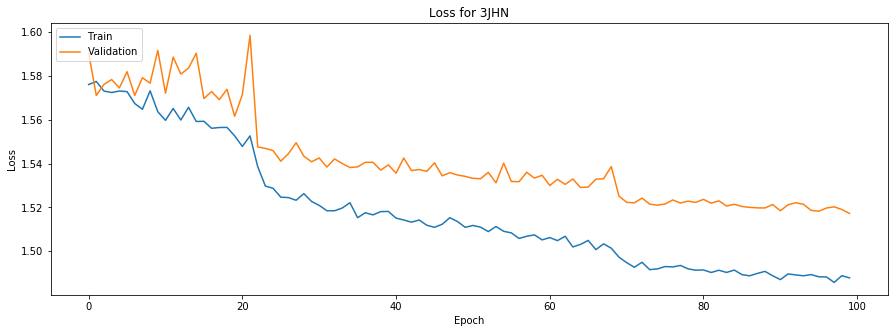

2019-08-01 14:44:57,573 | INFO : Plotting Results


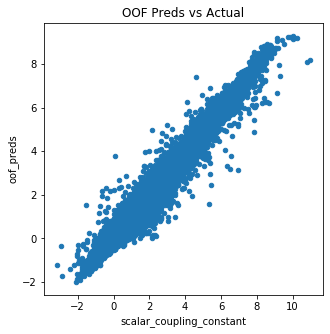

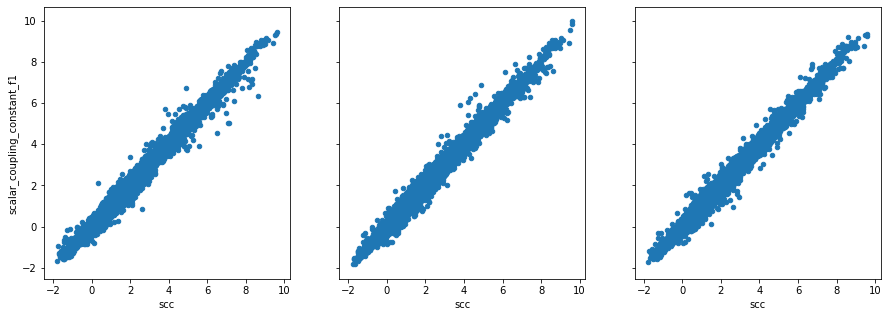

2019-08-01 14:45:03,095 | INFO : Saving Results


NameError: name 'run_id' is not defined

In [14]:
EPOCH_N = 500
INPUT_MODEL = 'M055_0726_2356_3JHN'
bond_type = '3JHN'
# cv_score=[]
# cv_score_total=0
verbose = 2

test = pd.read_csv('../input/test.csv')

oof = train.loc[train['type'] == bond_type].reset_index(drop=True).drop(['molecule_name','atom_index_0','atom_index_1'], axis=1)
sub = test.loc[test['type'] == bond_type]

for fold in [1, 2, 3]:
    # Find the correct input filename for this fold
    for f in os.listdir(f'../type_results/{bond_type}/meta'):
        if ('X_train' in f) and (INPUT_MODEL in f) and (f'_f{fold}_' in f):
            X_train_file = f
    logger.info(f'Using X_train file {X_train_file}')
        
    cv_predict, test_predict, val_idx = train_keras_model(fold=fold,
                                                          MODEL_NUMBER=MODEL_NUMBER,
                                                          bond_type=bond_type,
                                                          X_train_file=X_train_file,
                                                          EPOCH_N=EPOCH_N)
    oof.loc[oof.index.isin(val_idx), 'oof_preds'] = cv_predict[0][:,0]
    sub[f'scalar_coupling_constant_f{fold}'] = test_predict[0][:,0]
    
#run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)

2019-08-01 14:46:36,863 | INFO : Plotting Results


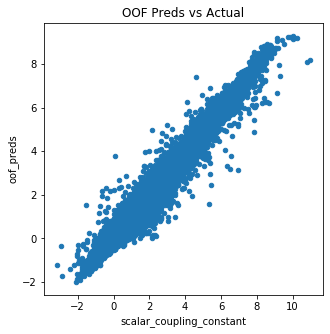

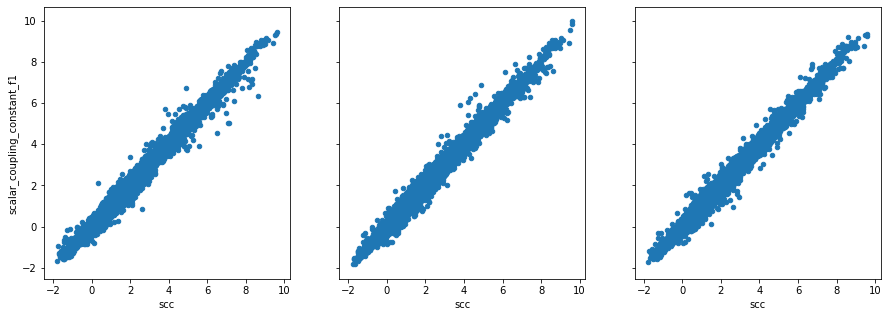

2019-08-01 14:46:42,161 | INFO : Saving Results
===== Saving results for for type 3JHN - mae 0.10186040235204283 - log mae -2.2841520074839723
2019-08-01 14:46:42,925 | INFO : 3JHN: Saving sub to ../type_results/3JHN/K004_0801_1446_3JHN_sub_0.1019MAE_-2.284LMAE_keras_3folds_iter_lr.parquet
2019-08-01 14:46:42,926 | INFO : 3JHN: Saving oof to ../type_results/3JHN/K004_0801_1446_3JHN_oof_0.1019MAE_-2.284LMAE_keras_3folds_iter_lr.parquet


In [15]:
run_id = "{:%m%d_%H%M}".format(datetime.now())
logger.info('Plotting Results')
oof.plot(x='scalar_coupling_constant', y='oof_preds', kind='scatter', figsize=(5, 5), title='OOF Preds vs Actual')
plt.show()

df = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv') # Pull a good submission
sub['scc'] = df['scalar_coupling_constant']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sub.plot(x='scc', y='scalar_coupling_constant_f1', kind='scatter', ax=ax1)
sub.plot(x='scc', y='scalar_coupling_constant_f2', kind='scatter', ax=ax2)
sub.plot(x='scc', y='scalar_coupling_constant_f3', kind='scatter', ax=ax3)
plt.show()

sub['scalar_coupling_constant'] = sub[['scalar_coupling_constant_f1',
                                       'scalar_coupling_constant_f2',
                                       'scalar_coupling_constant_f3']].mean(axis=1)
logger.info('Saving Results')
save_type_data(
    type_=bond_type,
    oof=oof,
    sub=sub.drop('type', axis=1),
    fi=None,
    MODEL_NUMBER=MODEL_NUMBER,
    run_id=run_id,
    MODEL_TYPE='keras',
    N_FOLDS=3,
    N_ESTIMATORS='',
    LEARNING_RATE='',
)